In [ ]:
# importing vital libraries
import os
import numpy as np
import pandas as pd
import time
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import is_numeric_dtype
import collections
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import normalized_mutual_info_score, mutual_info_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree

### Phase 0 - EDA and Visualization

In [ ]:
#reading the csv file
df = pd.read_csv('dataset.csv')

In [ ]:
# describe
df.describe()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,30000.000000,30000.000000,30000.000000,2.699000e+04,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,27067.000000,30000.000000
mean,47.769533,0.359661,0.540929,2.466460e+05,0.556709,0.180807,0.183610,-10.079862,0.083861,117.559824,0.446563
std,14.512665,0.364182,0.181719,1.126005e+05,0.277856,0.329365,0.150733,6.953936,0.093366,30.719934,0.248745
min,0.000000,0.000001,0.059600,1.550900e+04,0.000792,0.000000,0.015700,-47.046000,0.022300,34.347000,0.000000
25%,39.000000,0.029600,0.423000,1.904930e+05,0.361000,0.000000,0.095800,-12.057250,0.035000,92.340000,0.243000
50%,49.000000,0.205000,0.553000,2.245600e+05,0.602000,0.000089,0.122000,-7.623000,0.045100,115.491000,0.435000
75%,57.000000,0.710000,0.671000,2.726670e+05,0.786000,0.125250,0.222000,-5.429750,0.080300,139.817500,0.639000
max,99.000000,0.996000,0.977000,3.195440e+06,0.998000,0.994000,0.996000,1.342000,0.941000,219.331000,0.985000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artist_name       28506 non-null  object 
 1   track_name        30000 non-null  object 
 2   popularity        30000 non-null  float64
 3   acousticness      30000 non-null  float64
 4   danceability      30000 non-null  float64
 5   duration_ms       26990 non-null  float64
 6   energy            30000 non-null  float64
 7   instrumentalness  30000 non-null  float64
 8   key               30000 non-null  object 
 9   liveness          30000 non-null  float64
 10  loudness          30000 non-null  float64
 11  mode              30000 non-null  object 
 12  speechiness       30000 non-null  float64
 13  tempo             27067 non-null  float64
 14  valence           30000 non-null  float64
 15  music_genre       30000 non-null  object 
dtypes: float64(11), object(5)
memory usage: 

____________________________________________

#### The general structure of data

Above, we can see that a minimum of 30000 samples are available in the csv file to help us understand the relationship between various categorical and numerical features with the genre of a track. We can also conclude that there are missing values that need filling and that scalling is needed over all the values (since the range varies for different columns).

______________________________________________

In [ ]:
percent_missing = df.isnull().sum() * 100 / len(df)
percent_missing

artist_name          4.980000
track_name           0.000000
popularity           0.000000
acousticness         0.000000
danceability         0.000000
duration_ms         10.033333
energy               0.000000
instrumentalness     0.000000
key                  0.000000
liveness             0.000000
loudness             0.000000
mode                 0.000000
speechiness          0.000000
tempo                9.776667
valence              0.000000
music_genre          0.000000
dtype: float64

________________________

#### The missing values

The percentage of missing values are shown above. From that, we can conclude that missing values are available only in three features and make up approximately from 5 to 10 percent of the data which cannot be ignored for teaching the model.
_______________________________

In [ ]:
def draw_violonplot(feature):
    
    sns.violinplot(x="music_genre", y=feature, data=df, palette="Set3", inner=None, scale="count") 
    plt.title("Violinplot of the Distribution of {} per music genre".format(feature))

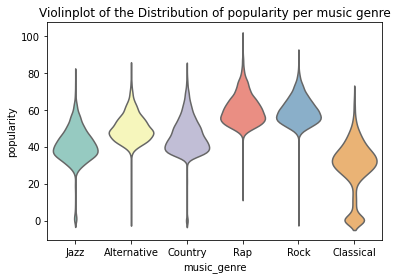

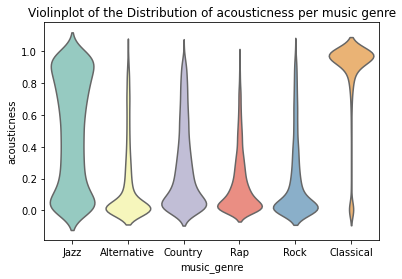

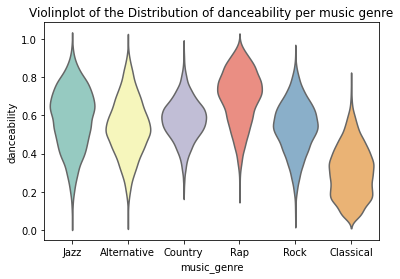

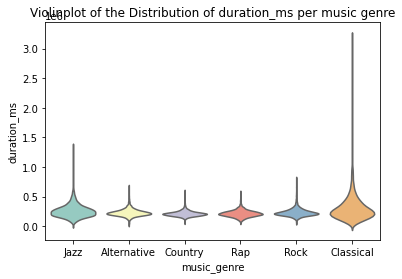

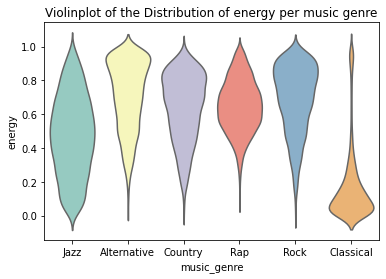

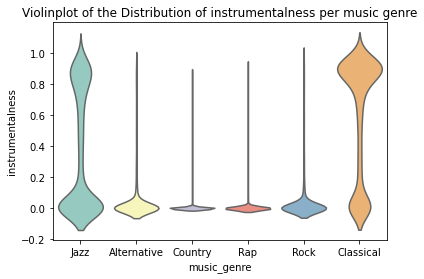

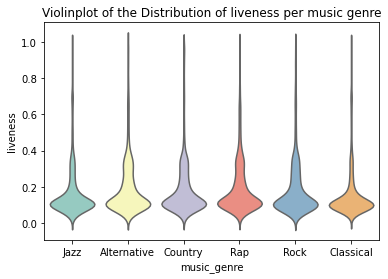

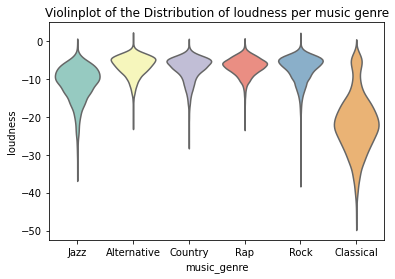

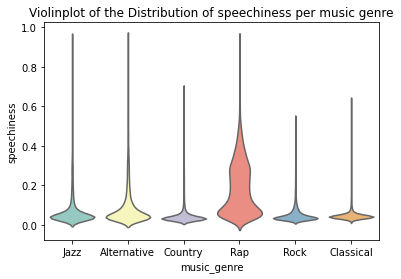

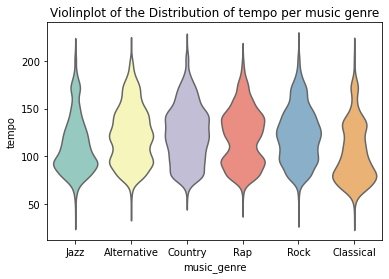

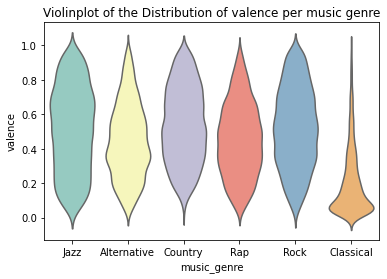

In [ ]:
for feature in df.columns:
    
    if is_numeric_dtype(df[feature]):
        draw_violonplot(feature)
        plt.show()

In [ ]:
def draw_kde_plt(feature):

    sns.kdeplot(df[feature], linewidth=2) 

    plt.title("KDE Plot of {}".format(feature)) 
    plt.ylabel("Density") 
    plt.xlabel(feature)
    plt.show()

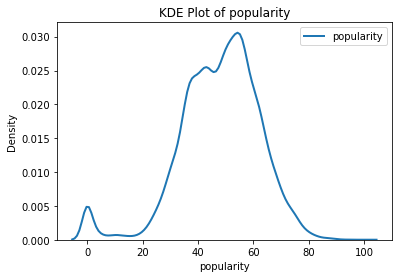

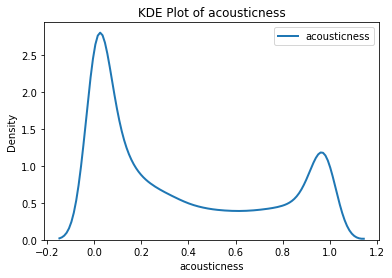

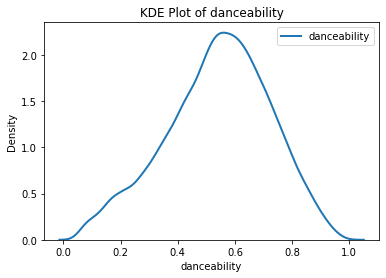

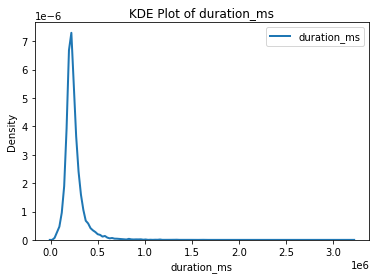

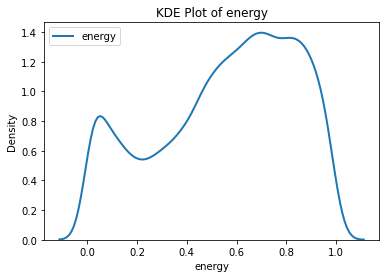

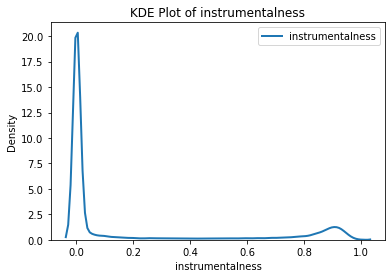

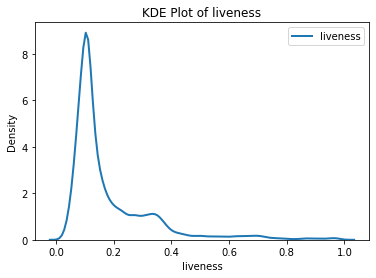

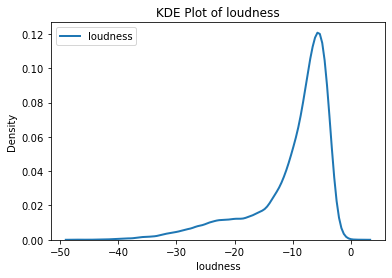

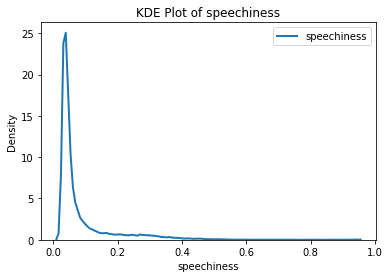

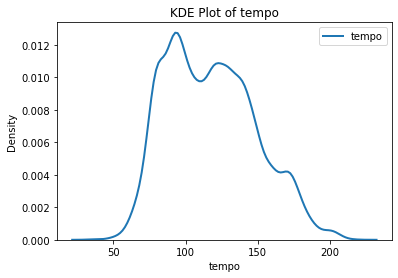

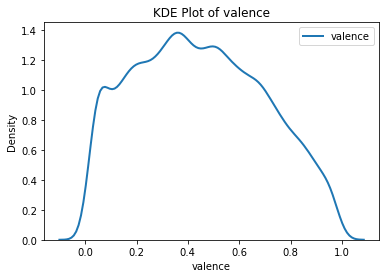

In [ ]:
for feature in df.columns:
    
    if is_numeric_dtype(df[feature]):
        draw_kde_plt(feature)
        plt.show()

#### The distribution of numerical data

The distribution of numerical values vary depending on their shape.

    - normal: danceability, duration_ms
    - Skewed Distribution: speechiness, loudness
    - Double-peaked or bimodel: liveness, instrumentalness, energy, acousticness
    - Plateau or multimodel: valence, tempo, popularity

In [ ]:
def plot_hist(feature, bin_num=30):
    
    subset = df[feature].dropna()
    plt.hist(subset, bin_num)
    plt.xlabel(feature) 
    plt.ylabel("Count") 
    plt.title("Histogram of {}".format(feature))
    plt.show()

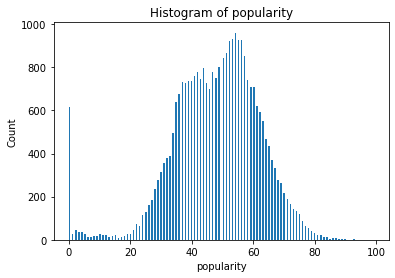

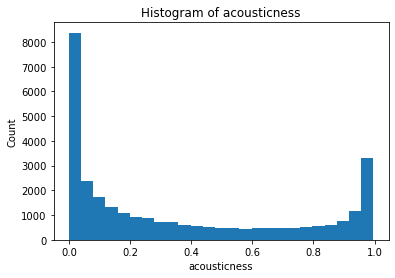

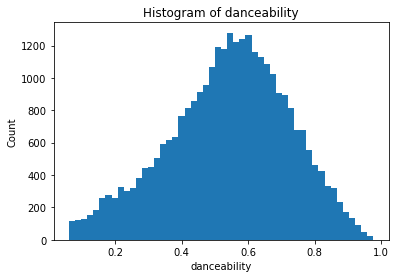

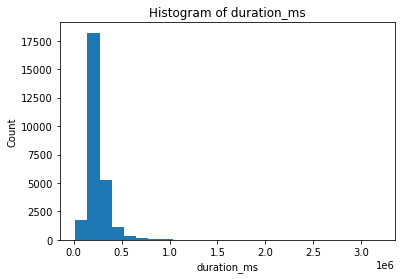

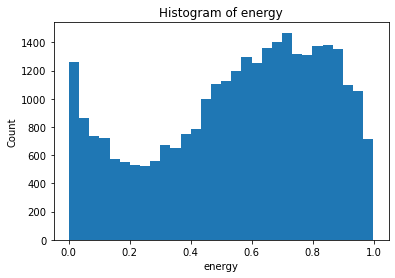

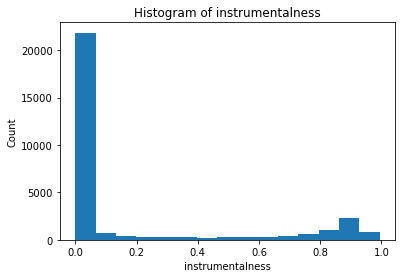

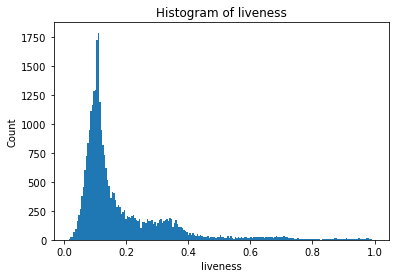

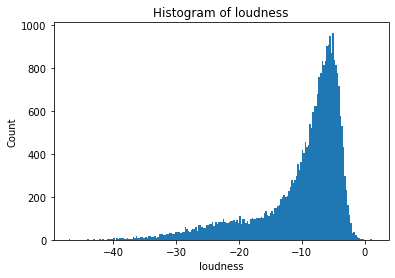

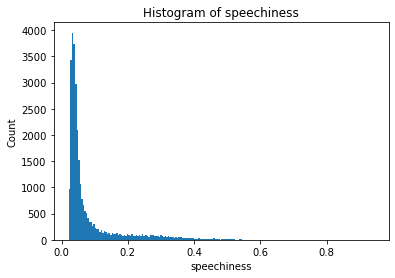

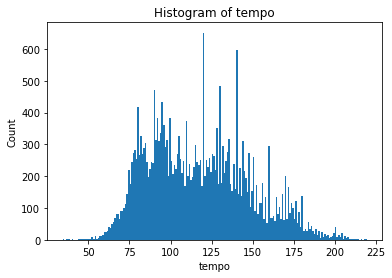

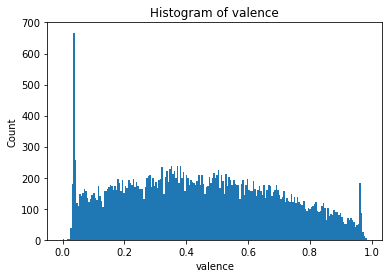

In [ ]:
bins = [200, 25, 50, 25, 30, 15, 200, 200, 200, 200, 200]
i = 0

for feature in df.columns:
    
    if is_numeric_dtype(df[feature]):
        bin_num = bins[i]
        i += 1
        plot_hist(feature, bin_num)

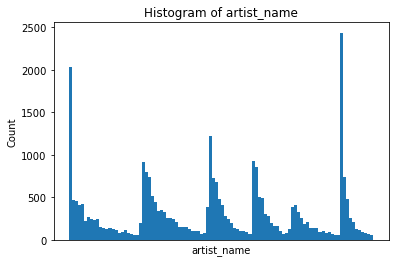

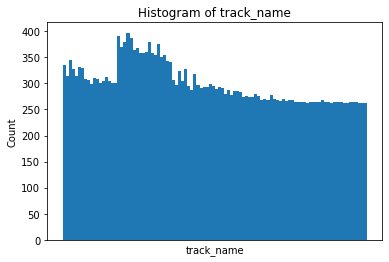

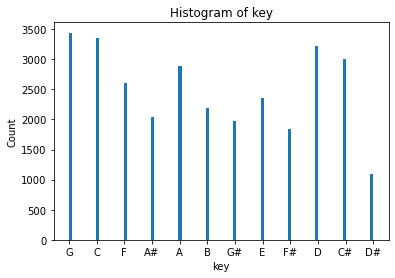

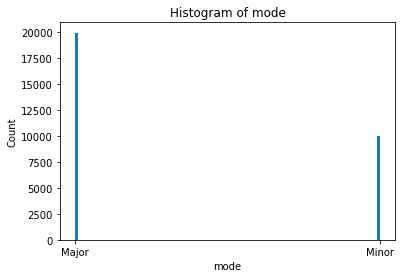

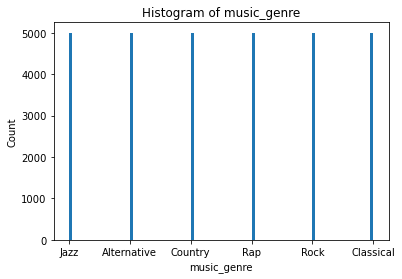

In [ ]:
for feature in df.columns:
    
    if not is_numeric_dtype(df[feature]):
        
        plt.hist(df[feature].astype(str).replace('\$\$',''), 100)
        if feature in ['artist_name', 'track_name']:
            plt.xticks([])
        plt.xlabel(feature) 
        plt.ylabel("Count") 
        plt.title("Histogram of {}".format(feature))
        plt.show()

## Phase 1 - Preprocessing


#### PART 1 -  How to manage lost data

1. Deleting the rows with missing data
2. Deleting the columns with missing data
    - pros: deleting a row or a column leads to the complete removal of the missing values and results in robust and highly accurate model.
    - cons: loss of information and poor performance in occasions where the percentage of missing values is high or the dataset is small
        
3. Filling the missing data with the mean or median value if it’s a numerical variable.
4. Filling the missing data with mode if it’s a categorical value.
    - pros: better than deleting data especially when the dataset is small (prevents data loss)
    - cons: has worse performance comparing to other filling strategies and might add variance and bias to the data
        
5. Filling the numerical value with 0 or -999, or some other number that will not occur in the data.
6. Filling the categorical value with a new type for the missing values.
    - pros: low variance after one hot encoding. Negating the loss of data by adding a new category.
    - cons: adds another feature to the model which may result in poor performance.
        
7. Predicting missing values (e.g. using a regression model)
    - pros: helps the model to have an unbiased estimation
    - cons: Can increase bias under special circumstances

8. Using models that suport missing values
    - pros: deos not require creating a model.
    - cons: being a time-consuming process
    
    
    
    
#### PART 2

We have three columns that have empty cells: "tempo", "artist_name", and "duration_ms", two of which are numerical. For filling the NaN values, we replace the values in artist_name all with a name not currently present in dataframe ('AAAAA'). The values in duration_ms and tempo are filled with linear interpolation and the column's mean, respectively.

In [ ]:
df['artist_name'] = df['artist_name'].replace(to_replace = np.nan, value = 'AAAAA') 
df['duration_ms'] = df['duration_ms'].interpolate(method ='linear', limit_direction ='forward')
tempo_mean = df["tempo"].mean()
df["tempo"] = df["tempo"].replace(to_replace = np.nan, value = tempo_mean)

In [ ]:
percent_missing_new = df.isnull().sum() * 100 / len(df)
percent_missing_new

artist_name         0.0
track_name          0.0
popularity          0.0
acousticness        0.0
danceability        0.0
duration_ms         0.0
energy              0.0
instrumentalness    0.0
key                 0.0
liveness            0.0
loudness            0.0
mode                0.0
speechiness         0.0
tempo               0.0
valence             0.0
music_genre         0.0
dtype: float64

#### PART 3 - Standarzation and Normalization

Feature scaling is one of the most important data preprocessing step in machine learning. Algorithms that compute the distance between the features are biased towards numerically larger values if the data is not scaled. Tree-based algorithms are fairly insensitive to the scale of the features. Also, feature scaling helps machine learning, and deep learning algorithms train and converge faster.

Normalization or Min-Max Scaling is used to transform features to be on a similar scale. The new point is calculated as:

X_new = (X - X_min)/(X_max - X_min)

This scales the range to [0, 1] or sometimes [-1, 1].

Standardization or Z-Score Normalization is the transformation of features by subtracting from mean and dividing by standard deviation. This is often called as Z-score.

X_new = (X - mean)/Std

Standardization can be helpful in cases where the data follows a Gaussian distribution. Standardization does not get affected by outliers because there is no predefined range of transformed features.


So in conclusion, the followings are the benefits of standarzation and normalization:

    1. reduces bias toward large data.
    2. helps ML and DL algorithms converge faster.
    3. (for standarzation) The output's dependance on outliers is reduced.
    
    
#### PART 4 - What scaling method to use

Since the distribution of the data is close to normal, we use standarzation which is both a robust method and fit for Gaussian distributions. In addition, it does not get affected by the outlier which are present in our data.

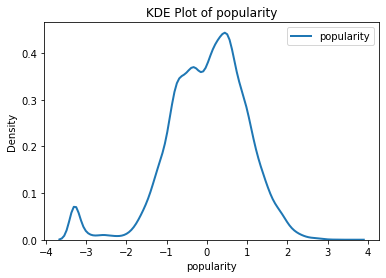

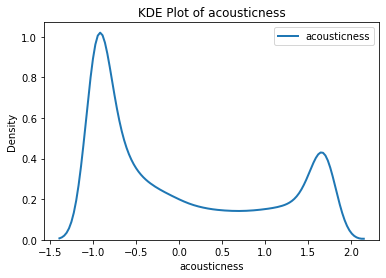

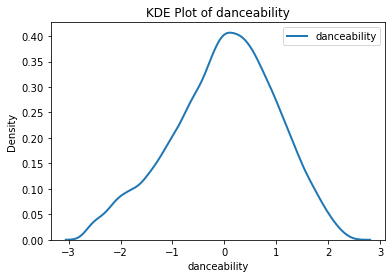

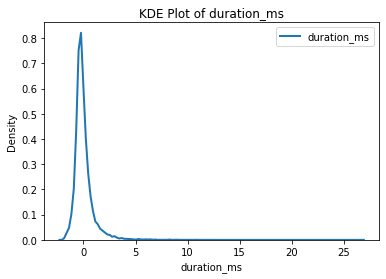

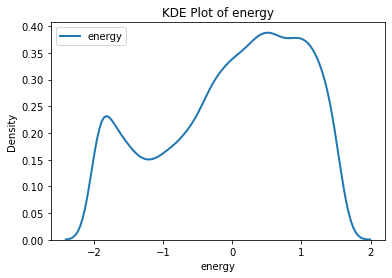

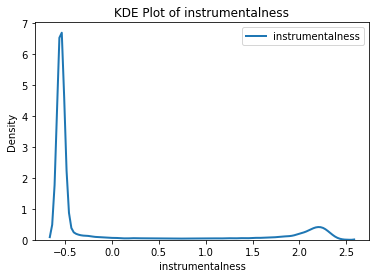

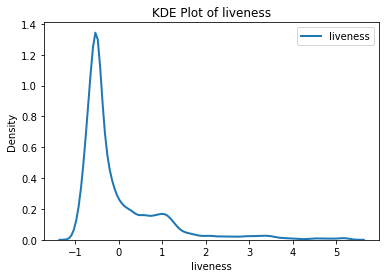

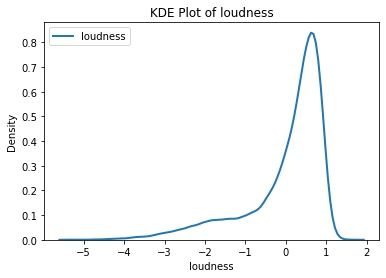

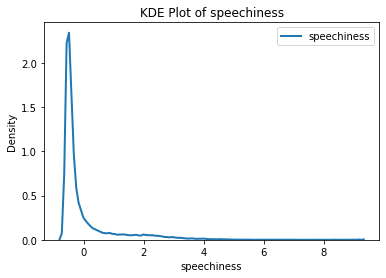

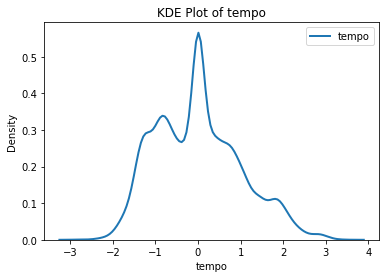

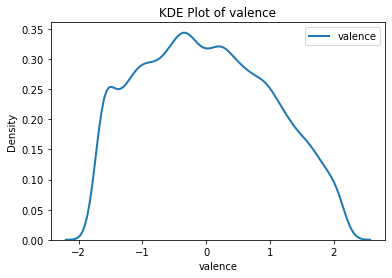

In [ ]:
for feature in df.columns:
    
    if is_numeric_dtype(df[feature]):
        df[feature] = (df[feature] - df[feature].mean())/df[feature].std()
        draw_kde_plt(feature)

#### PART 5 - Categorical Feature Encoding



###### Method 1 - Assigning a number

In this method, we assign a number to each elemnt in the category. Though this approach is easy to handle categorical variables, by assigning a number to each of the elements an artificial order is created which is not genuine, and to solve this problem we use another method called one-hot encoding.

###### Method 2 - One-hot encoding

In this method we create n more features for the n cetegories of the features. In other words, one hot encoding creates a binary vector of the size of the number of distinct elements. The biggest advantage of this method is that we get rid of the artificial ordering that we were facing in method 1. This approach can create problems if the number of different elements of a categorical value is a lot. Another problem is if the number of distinct values for a categorical feature is large then one hot encoding can create sparse and large vectors; meaning that the output can hold number 1 in more than one category.

###### Method 3 - Frequency Bases Embeddings

Frequency based embeddings vectorize the text depending on the frequency of occurrence of the words in the text/document. The words in the texts are vectorized using frequency based vectorizer such as countvectorizer. Then the documents are trained based on the vectors obtained by frequency vectorization. Model prepared will be able to predict the document type. This is because the frequency of some of the words will be more in each type of document. A technology document will have a different set of words compared to a document of politics or economics.

###### Method 4 - CountVectorizer

CountVectorizer is a very simple vectorizer which gets the frequency of the words in the text. CountVectorizer is used convert the collection of text documents to the word/token counts.Count vectorization can be done with the CountVectorizer from Sklearn.


In this part we use one hot encoding for "mode" and for other categorical features namely, artist_name, track_name, key, and genre.

In [ ]:
def ordinal_encode(feature):
    
    oe = OrdinalEncoder()
    x = [[w] for w in df[feature]]
    oe.fit(x)
    return oe.transform(x)


def label_encode(feature):
    
    le = LabelEncoder()
    x = [w for w in df[feature]]
    le.fit(x)
    return le.transform(x)

In [ ]:
genre_orig = list(df['music_genre'])

df['artist_name'] = ordinal_encode('artist_name')
df['track_name'] = ordinal_encode('track_name')
df['key'] = ordinal_encode('key')
df['music_genre'] = ordinal_encode('music_genre')
df['mode'] = label_encode('mode')

genre_encoded = list(df['music_genre'])
genre_dict = dict(zip(genre_orig, genre_encoded))
print(genre_dict)

{'Jazz': 3.0, 'Alternative': 0.0, 'Country': 2.0, 'Rap': 4.0, 'Rock': 5.0, 'Classical': 1.0}


In [ ]:
df

,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
0,532.0,3959.0,-0.259741,-0.970532,0.935904,0.356317,0.231381,-0.458783,10.0,-0.163272,0.381203,0,-0.489052,8.398059e-01,0.644987,3.0
1,1512.0,4560.0,-0.948794,-0.034765,1.034959,-1.295057,-0.150111,-0.527946,3.0,-0.375567,-0.009655,0,1.072549,-1.288258e+00,-0.641471,3.0
2,583.0,24622.0,0.222596,-0.937884,0.704778,-0.728712,1.181513,2.122853,10.0,0.539958,0.431391,1,-0.493336,-2.751628e-13,0.761572,3.0
3,3211.0,534.0,-0.604268,1.533131,-0.313279,-0.162367,-1.754179,-0.548746,8.0,-0.295956,-0.785474,0,-0.527610,-1.194425e+00,-0.967105,3.0
4,2875.0,18335.0,-0.810984,-0.892852,-0.373812,0.871613,0.958376,0.805165,10.0,0.811962,0.496821,0,-0.223430,-4.409188e-01,-0.255534,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,4925.0,5465.0,-1.775658,1.513910,-1.182754,1.105100,-1.524924,-0.548956,10.0,-0.355665,-1.497445,0,-0.301617,-8.728649e-01,-0.967105,1.0
29996,3177.0,21037.0,-1.500037,1.662188,-2.283356,2.423896,-1.269396,2.089455,2.0,-0.514887,-0.919499,0,-0.475128,-1.203678e+00,-1.639681,1.0
29997,1663.0,2618.0,0.429312,1.692392,-0.979143,0.140342,-1.589705,-0.548956,5.0,-0.559999,-1.041876,0,-0.160237,-2.751628e-13,-0.866601,1.0
29998,1331.0,16195.0,-0.397552,1.717105,-2.299865,0.117024,-1.940966,2.201793,7.0,-0.388836,-1.954453,0,-0.461204,-1.571470e+00,-1.653752,1.0


____________________________________
#### PART 6 - Using artist_name as a useful feature

As seen in the last part, nominal values (which are a subcategory of categorical data) can be encoded to numbers and integers in many ways four of which is explained above. in order to use artist name as a usefule feature, we need to avoid a character by character approach since the genre is interrelated with the artist him/herself not the characters of his/her name. In order to solve the problem of the artificial order given, we can use one-hot encoding but since the number of names used is a lot, the dimension of the feature vector will increase a lot (5090 new features for the 5090 names used.) As a result, the integer value of the names will be used without one-hot encoding

_______________________________________________

#### PART 7 - Calculating Information Gain

In this part we calculate the information gain of each feature using mutual_info_classif function of sklearn.

In [ ]:
music_genre = df['music_genre']
x_features = df.copy()
x_features.drop(['music_genre'], axis=1, inplace=True)
information_gains = mutual_info_classif(x_features, music_genre)
data = {'feature':list(df.columns[0:-1]), 'information gain':information_gains} 
df_IG = pd.DataFrame(data)
df_IG

,feature,information gain
0,artist_name,1.196743
1,track_name,0.314446
2,popularity,0.497778
3,acousticness,0.360371
4,danceability,0.279152
5,duration_ms,0.113214
6,energy,0.325424
7,instrumentalness,0.296794
8,key,0.020000
9,liveness,0.010773


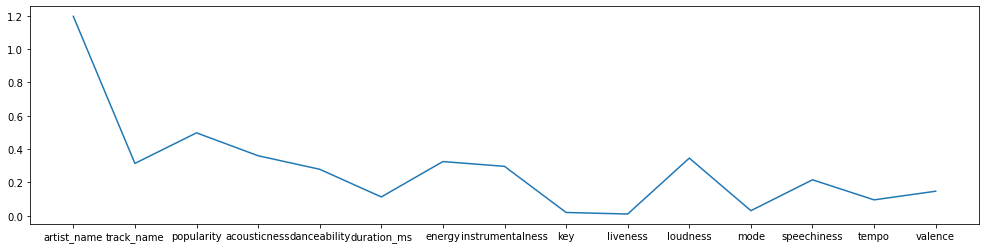

In [ ]:
plt.figure(figsize=(17, 4))
plt.plot(df_IG['feature'], df_IG['information gain'])

_______________________________________________

### PART 8 - Possible Removal of Features


Not all features are that helpful in training machine learning models. Some features might act almost independant of the output and others might be a subcategory of others. In addition, some features might increase model's accuracy only for a small bit and removing them to have one less dimension to the data (especially if the dataset is large.) In these cases and many others, an operation of feature selection is used. 

Pros: By doing feature selection, we can have a better understanding of the problem while removing the redundant attributes that can be potentially misleading (Instance-based methods such as k-nearest neighbor can be greatly skewed by redundant attributes.) In addition, keeping irrelevant attributes can result in overfitting. Other benefits of feature selection include improving accuracy and reducing training time. 

Cons: We perform feature selection to train simpler models in shorter times but it is often true that the task of feature selection by itself is that much slower that diminishes the benefit of the time consumed by removing the features. Another shortcoming of feature selection algorithms is that they seek to identify only one solution to the problem. However, in practice, it is often the case that multiple predictive or even information equivalent solutions exist. Especially in domains with inherent redundancy present in the underlying problem. While a single solution is acceptable for building an optimal predictive model, it is not sufficient when feature selection is applied for knowledge discovery. In fact, it may even be misleading. For example, if several sets of risk factors in a medical study are collectively equally predictive for an event, then it is misleading to return only one of them and claim that the rest are superfluous.



##### Useful features for training our model

track_name and artist_name are useful features, since singers work with cetain genres and the content of the track is reflected in its name. Still, getting information out of track_name needs natural language processing and might not be informative if the data is encoded character by character (as is done now.)

Popularity feature can be useful if the majority of people prefer some kind of music over the other (which is true in our case as seen in the violinplots of the popularity feature.)
Duration feature could be counted independant from the music_genre feature since there are no obvious causation or correlation relationship between them. 

As for mode feature, many studies show that there are differences in modes across various genres so they are not independant from each other, and training the model using the mode feature can still be beneficial. 

The key feature is also interrelated with music genre but not totally. There are some keys that are more likely to be seen in some genres and there are other keys that have an approximately equal possibility of being used in various music genres.

Other features prove to have a strong relationship with our target feature and are therefore used in the model.

By combining these facts with the result of information gain calculation, we conclude that:

    - useful features: acousticness, danceability, energy, instrumentalness, loudness, speechiness, valence, artist_name, popularity
    - possibily useful features: duration_ms
    - features to be removed: tempo, mode, liveness, key

In [ ]:
pre_df = df.copy()
pre_df.drop(['tempo', 'mode', 'liveness', 'key'], axis=1, inplace=True)
pre_df

,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,loudness,speechiness,valence,music_genre
0,532.0,3959.0,-0.259741,-0.970532,0.935904,0.356317,0.231381,-0.458783,0.381203,-0.489052,0.644987,3.0
1,1512.0,4560.0,-0.948794,-0.034765,1.034959,-1.295057,-0.150111,-0.527946,-0.009655,1.072549,-0.641471,3.0
2,583.0,24622.0,0.222596,-0.937884,0.704778,-0.728712,1.181513,2.122853,0.431391,-0.493336,0.761572,3.0
3,3211.0,534.0,-0.604268,1.533131,-0.313279,-0.162367,-1.754179,-0.548746,-0.785474,-0.527610,-0.967105,3.0
4,2875.0,18335.0,-0.810984,-0.892852,-0.373812,0.871613,0.958376,0.805165,0.496821,-0.223430,-0.255534,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
29995,4925.0,5465.0,-1.775658,1.513910,-1.182754,1.105100,-1.524924,-0.548956,-1.497445,-0.301617,-0.967105,1.0
29996,3177.0,21037.0,-1.500037,1.662188,-2.283356,2.423896,-1.269396,2.089455,-0.919499,-0.475128,-1.639681,1.0
29997,1663.0,2618.0,0.429312,1.692392,-0.979143,0.140342,-1.589705,-0.548956,-1.041876,-0.160237,-0.866601,1.0
29998,1331.0,16195.0,-0.397552,1.717105,-2.299865,0.117024,-1.940966,2.201793,-1.954453,-0.461204,-1.653752,1.0


## Phase 2 - Preprocessing



### PART 1 and 2 - Splitting samples into train and test parts


##### Splitting the data into train and test
Assigning 80 percent of data to train (and validation) and 20 percent to test is a rule of thumb and widely used.

##### Shuffling data
Shuffling training data, both before training and between epochs, helps prevent model overfitting by ensuring that batches are more representative of the entire dataset (in batch gradient descent) and that gradient updates on individual samples are independent of the sample ordering (within batches or in stochastic gradient descent); the end-result of high-quality per-epoch shuffling is better model accuracy after a set number of epochs.

##### Having the same number of samples for each category
The skewed distribution makes many conventional machine learning algorithms less effective, especially in predicting minority class examples. In addition, if the train dataset is skewed, classifier may get biased towards the prediction. (Since the optimization on loss function goes more toward predicting the class with higher number of samples.)

In the case for test dataset, having an skewed dataset can increase/decrease accuracy without model being that good/bad. To put it in another way, if the dataset is skewed, the parameters such as accuracy are more a reflection of the model's performance on the category with higher number of samples than others. 

##### Stratify parameter in train_test_split
The stratify parameter makes a split so that the proportion of values in the sample produced will be the same as the proportion of values provided to parameter stratify. For example, if variable y is a binary categorical variable with values 0 and 1 and there are 25% of zeros and 75% of ones, stratify=y will make sure that your random split has 25% of 0's and 75% of 1's.
If not None, data is split in a stratified fashion, using this as the class labels.



In [ ]:
df_train, df_test = train_test_split(pre_df, test_size=6000, train_size=24000, shuffle=True)

In [ ]:
train_y = df_train['music_genre']
train_x = df_train.copy()
train_x.drop(['music_genre'], axis=1, inplace=True)

test_y = df_test['music_genre']
test_x = df_test.copy()
test_x.drop(['music_genre'], axis=1, inplace=True)

### PART 3 - KNN Model



In [ ]:
scores_train = []
scores_test = []

for i in range(1, 50):
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(train_x, train_y)
    scores_train.append(accuracy_score(train_y, neigh.predict(train_x)))
    scores_test.append(accuracy_score(test_y, neigh.predict(test_x)))

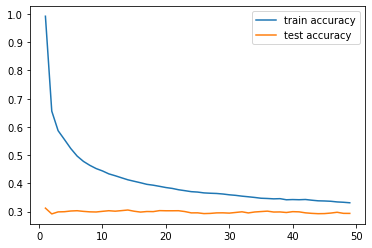

In [ ]:
plt.plot(range(1, 50), scores_train, label='train accuracy')
plt.plot(range(1, 50), scores_test, label='test accuracy')
plt.legend()
plt.show()

The model is obviously being underfitted more and more as the N numbre increases. The results in test shows us that the training is not being performed well

### PART 4 - Decision Tree Model

In [ ]:
scores_train_dt = []
scores_test_dt = []

for i in range(1, 50):
    
    dt = tree.DecisionTreeClassifier(max_depth=i)
    dt.fit(train_x, train_y)
    scores_train_dt.append(accuracy_score(train_y, dt.predict(train_x)))
    scores_test_dt.append(accuracy_score(test_y, dt.predict(test_x)))

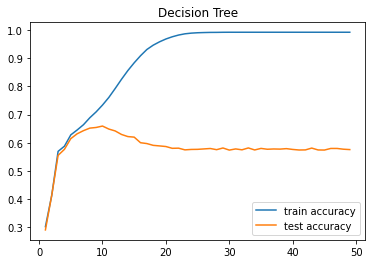

In [ ]:
plt.plot(range(1, 50), scores_train_dt, label='train accuracy')
plt.plot(range(1, 50), scores_test_dt, label='test accuracy')
plt.title('Decision Tree')
plt.legend()
plt.show()

In [ ]:
scores_train_dt = []
scores_test_dt = []

for i in range(1, 50):
    
    dt = tree.DecisionTreeClassifier(min_samples_leaf=i)
    dt.fit(train_x, train_y)
    scores_train_dt.append(accuracy_score(train_y, dt.predict(train_x)))
    scores_test_dt.append(accuracy_score(test_y, dt.predict(test_x)))

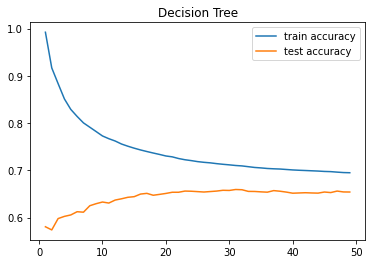

In [ ]:
plt.plot(range(1, 50), scores_train_dt, label='train accuracy')
plt.plot(range(1, 50), scores_test_dt, label='test accuracy')
plt.title('Decision Tree')
plt.legend()
plt.show()

As seen above, the model is getting underfitted as min_sample_leaf increases but the model peforms better on out test dataset. On the other hand, as max_depth of the tree increases, overfitting happens. We can also conclude that, the best max_depth of the tree is around 8, where test accuracy peaks.